In [4]:
import math
import torch.nn as nn
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import torchtext

C:\Users\Will_\miniconda3\envs\csc413\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Step1 Load the data**

In [5]:
import dataloader
creature_imgs, creature_captions =dataloader.get_torch_creature_data() 

## **Step2 Process the data**
Turn both the image and captions in to embeddings,\
For images we are using **Alexnet** to obtain the features
For captions we are using Character by character **onehot** embeddings

* Character by character Onehot embedding

In [6]:
# use { and } as start of the sentence and end of sentence
# use @ as padding
def get_word_vocab(tokens):
    return list(set([i for token in tokens for i in token] ))+ ["{", "}"] + ["@"]
    

In [7]:
creature_tokens = [i.replace(".", " . ").replace(",", " , ").replace(";", " ; ").replace("?", " ? ").lower().split() for i in creature_captions]

In [8]:
vocab = get_word_vocab(creature_tokens)

In [9]:
vocab_stoi = {vocab[i] :i for i in range(len(vocab))}
vocab_itos = {i:vocab[i] for i in range(len(vocab))}    

In [10]:
def make_torch_token(sentences, vocab):
    tokens = []
    for sentence in sentences:
        token = [vocab_stoi["{"]] + [vocab_stoi[character] for character in sentence] + [vocab_stoi["}"]]
        tokens.append(token)
    return np.array(tokens)

In [11]:
def make_onehot(tokens,vocab):
    
    word_onehot = torch.eye(len(vocab))
    onehot_sentences = []
    for token in tokens:
        torch_onehot_sentence = word_onehot[token.int().tolist()]
        onehot_sentences.append(torch_onehot_sentence.unsqueeze(0))
    
    return onehot_sentences

In [12]:
def get_sentence_from_onehot(sentences, vocab):
    readable_sentences = []
    for sentence in sentences:
        readable_sentence = [vocab[torch.argmax(character)] for character in sentence]
    
        readable_sentences.append(readable_sentence)
         
    return readable_sentences

In [13]:
token_creature_captions = make_torch_token(creature_tokens,vocab)

C:\Users\Will_\AppData\Local\Temp\ipykernel_30140\639020239.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(tokens)


In [14]:
def get_padded_onehot_from_token(tokens):
    
    word_onehot = torch.eye(len(vocab))
    onehot_sentences=[]
    padded_tokens = pad_sequence(tokens,padding_value=vocab_stoi["@"],batch_first=True)
    
    for token in padded_tokens:
        
        torch_onehot_sentence = word_onehot[token.int().tolist()]
        onehot_sentences.append(torch_onehot_sentence.unsqueeze(0))
    return torch.cat(onehot_sentences)

    

* Alexnet

        Load Alexnet 

In [15]:
alexnet = torchvision.models.alexnet(pretrained=True)


In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self,dropout_rate, input_dimensions,max_sequence_len, dimension2d=False):
        super(PositionalEncoding,self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.dimension2d = dimension2d
        positional_embedding = torch.zeros(input_dimensions,max_sequence_len)
        even = torch.arange(0,input_dimensions,2)
        odd = torch.arange(1,input_dimensions,2)
        position = torch.arange(max_sequence_len)
        denominator = torch.float_power(10000,even/input_dimensions)
        positional_embedding[0::2] = torch.sin(position.unsqueeze(0)/denominator.unsqueeze(1))
        positional_embedding[1::2] = torch.cos(position.unsqueeze(0)/denominator.unsqueeze(1))
        horizontal_positional_embedding = positional_embedding
        vertical_positional_embedding = positional_embedding
        if dimension2d:
            positional_embedding = horizontal_positional_embedding.unsqueeze(1) + vertical_positional_embedding.unsqueeze(2)
        else:
            positional_embedding = horizontal_positional_embedding.permute(1,0)
        self.register_buffer("positional_embedding",positional_embedding)
        
        
    def forward(self,x):
        if not self.dimension2d:
            
            x = x + self.positional_embedding[:x.shape[1],:].unsqueeze(0)
        else:

            x = x + self.positional_embedding[:,:x.shape[2],:x.shape[3]].unsqueeze(0)
        return self.dropout(x)       
        
        
        

In [43]:
class caption_transformer(nn.Module):
    def __init__(self,num_heads,hidden_size,dropout):
        super(caption_transformer,self).__init__()
        
        self.cnn_layer = nn.Conv2d(256,hidden_size,1)
        self.fc_layer = nn.Linear(4770,hidden_size)      
        self.transformer_layer = nn.Transformer(hidden_size,num_heads,batch_first=True,num_encoder_layers=6,num_decoder_layers=6)

        self.fc_layer2 = nn.Linear(hidden_size,hidden_size)
        self.fc_layer3 = nn.Linear(hidden_size,4770)
        
        self.positional_embedding_source = PositionalEncoding(dropout, hidden_size,10,dimension2d=True)
        self.positional_embedding = PositionalEncoding(dropout,hidden_size,300)
        
    def forward(self, inp, target,mask=True):
        
        emb_inp = alexnet.features.cuda()(inp)
       
        
        # embed the image
        emb_inp = torch.relu(self.cnn_layer(emb_inp))
        
        
        # positional embedding for source
        
        emb_inp2 = self.positional_embedding_source(emb_inp)
 
        # embed the text
        emb_target = self.fc_layer(target)
        
        # positional embedding for target
        emb_target2 = self.positional_embedding(emb_target) 
                
        tgt_mask = self.make_tgt_mask(emb_target2).to(device) if mask else None
        
        emb_inp2 = emb_inp2.flatten(2).transpose(1,2)
        out = self.transformer_layer(emb_inp2,emb_target2,tgt_mask=tgt_mask)
        out1 = self.fc_layer2(out)
        out2 = self.fc_layer3(out1)
        
        return out2
        
    def make_tgt_mask(self,tgt):
        M, N, tgt_len = tgt.shape
        tgt_mask = torch.tril(torch.ones((N,N)) ==1)
        tgt_mask = tgt_mask.float()
        tgt_mask = tgt_mask.masked_fill(tgt_mask==0, float('-inf'))
        tgt_mask = tgt_mask.masked_fill(tgt_mask ==1, float(0.0)) 
        return tgt_mask
        
        

In [35]:
class caption_transformer2(nn.Module):
    def __init__(self,num_heads,hidden_size,dropout):
        super(caption_transformer2,self).__init__()
        
        self.fc_layer_source = nn.Linear(36,hidden_size)
        
        self.fc_layer = nn.Linear(4770,hidden_size)      
        self.transformer_layer = nn.Transformer(hidden_size,num_heads,batch_first=True,num_encoder_layers=6,num_decoder_layers=6)

        self.fc_layer2 = nn.Linear(hidden_size,hidden_size)
        self.fc_layer3 = nn.Linear(hidden_size,4770)

        self.positional_embedding = PositionalEncoding(dropout,hidden_size,300)
        
    def forward(self, inp, target,mask=True):
        
        emb_inp = alexnet.features.cuda()(inp)
        emb_inp = emb_inp.flatten(2)
        
        # embed the image
        emb_inp = self.fc_layer_source(emb_inp)
        # positional embedding for source
        emb_inp2 = self.positional_embedding(emb_inp)
        # embed the text
        emb_target = self.fc_layer(target)
        # positional embedding for target
        emb_target2 = self.positional_embedding(emb_target)   
        tgt_mask = self.make_tgt_mask(emb_target2).to(device) if mask else None
        
        out = self.transformer_layer(emb_inp2,emb_target2,tgt_mask=tgt_mask)
        out1 = self.fc_layer2(out)
        out2 = self.fc_layer3(out1)
        
        return out2
        
    def make_tgt_mask(self,tgt):
        M, N, tgt_len = tgt.shape
        tgt_mask = torch.tril(torch.ones((N,N)) ==1)
        tgt_mask = tgt_mask.float()
        tgt_mask = tgt_mask.masked_fill(tgt_mask==0, float('-inf'))
        tgt_mask = tgt_mask.masked_fill(tgt_mask ==1, float(0.0)) 
        return tgt_mask
        
        

In [19]:
class My_Dataset(torch.utils.data.Dataset):
    def __init__(self, source, target):
        self.datasetA = source
        self.datasetB = target
    
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

In [20]:
def get_accuracy2(model, data,batch_size = 10):
    model.eval()
    num = 0
    correct = 0
    mini_batch = torch.utils.data.DataLoader(data,batch_size = batch_size)
    for x,y in mini_batch:
        N, S, W = y.shape 
        num+=N*S
        out = model(x,y[:,:-1,:])
        correct += torch.sum(torch.argmax(out,2) == torch.argmax(y[:,1:,:],2))
        return correct/num

In [21]:
def train2(model, train_data,valid_data, num_epoches=10, batch_size=30, \
                learning_rate = 0.1, weight_decay = 0,checkpoint_path = None):
    
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay=weight_decay)
    train_accs, val_accs  = [], [] 
    iters, losses = [], []
    n=0
    for epoch in range(num_epoches):
        mini_batch = torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle = True)
        num_update = 0
        
        for x,t in mini_batch:  
            model.train()
            num_update += 1

            y = model(x,t[:,:-1,:])
            
            loss = criterion(y,t[:,1:,:])
     
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
            
            n+=1
        iter = epoch
        
        train_cost = float(loss.cpu().detach().numpy())
        train_acc = get_accuracy2(model, train_data)
        val_acc = get_accuracy2(model, valid_data)
        print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                    iter, val_acc * 100, train_acc * 100, train_cost))
        #print("Iter %d.  [Train Loss %f]" % (
        #            iter,  train_cost))
        
        iters.append(iter)
        losses.append(loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(iter))

        
    plt.title("Training curve")
    plt.plot(iters, [i.cpu() for i in train_accs], label = "Train")
    plt.plot(iters, [i.cpu() for i in val_accs], label = "Valid")

    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.figure()
    plt.plot(iters,[i.cpu().detach().numpy() for i in losses], label = "Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    

In [22]:
def generate_captions(source,model):
      
      model.eval()
      start = get_padded_onehot_from_token([torch.Tensor([vocab_stoi['{']])]).to(device)
      end = get_padded_onehot_from_token([torch.Tensor(vocab_stoi['}'])]).to(device)
      temp = start
      for i in range(50):
            
            inter = model(source.unsqueeze(0).to(device),temp)
            combine = torch.cat((temp,inter[:,-1,:].unsqueeze(0)),dim=1)
            #temp = combine
            temp = emphesis(combine)
            #   if torch.argmax(temp[:,-1,:]) == torch.argmax(end):
            #       break
      readable = get_sentence_from_onehot(temp,vocab)
      
      return readable

In [23]:
def describe(n, model):
    model.eval()
    feature = creature_imgs[n:n+1].to(device)
    
    out = generate_captions(feature[0],model)
    plt.imshow(creature_imgs[n].int().permute(1,2,0))
    print(' '.join(out[0]))
   
    

In [24]:
def emphesis(onehot):
    temp = torch.argmax(onehot,dim = 2)
    return get_padded_onehot_from_token([i for i in temp]).to(device)

In [25]:
def describe2(n,model):
    feature = creature_imgs[n:n+1].to(device)
    target = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[n:n+1]]).to(device)
    out = model(feature,target)
    print(' '.join(get_sentence_from_onehot(out,vocab)[0]))

In [26]:
device = torch.device("cuda:0")

In [333]:
index = np.arange(8000)
np.random.shuffle(index)
index

array([3518, 4419, 3395, ..., 4241, 4198, 5576])

In [22]:
valid_pic = creature_imgs[6500:7500].to(device)
valid_caption = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[6500:7500]]).to(device)
valid_dataset = My_Dataset(valid_pic,valid_caption)

In [30]:
tiny_valid_features = creature_imgs[-20:].to(device)
tiny_valid_captions = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[-20:]]).to(device)
tiny_valid_data = My_Dataset(tiny_valid_features,tiny_valid_captions)

In [27]:
tiny_features = creature_imgs[:5].to(device)
tiny_captions = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[:5]]).to(device)
tiny_train_data = My_Dataset(tiny_features,tiny_captions)

In [1]:
cuda_tiny = caption_transformer(8,128,0.1).to(device)


NameError: name 'caption_transformer' is not defined

Iter 0. [Val Acc 0%] [Train Acc 0%, Loss 0.012662]
Iter 1. [Val Acc 0%] [Train Acc 0%, Loss 0.012503]
Iter 2. [Val Acc 0%] [Train Acc 0%, Loss 0.012489]
Iter 3. [Val Acc 0%] [Train Acc 0%, Loss 0.012500]
Iter 4. [Val Acc 0%] [Train Acc 0%, Loss 0.012551]
Iter 5. [Val Acc 0%] [Train Acc 0%, Loss 0.012473]
Iter 6. [Val Acc 0%] [Train Acc 0%, Loss 0.012536]
Iter 7. [Val Acc 0%] [Train Acc 0%, Loss 0.012521]
Iter 8. [Val Acc 0%] [Train Acc 0%, Loss 0.012452]
Iter 9. [Val Acc 0%] [Train Acc 0%, Loss 0.012442]
Iter 10. [Val Acc 0%] [Train Acc 0%, Loss 0.012432]
Iter 11. [Val Acc 0%] [Train Acc 0%, Loss 0.012488]
Iter 12. [Val Acc 0%] [Train Acc 0%, Loss 0.012477]
Iter 13. [Val Acc 0%] [Train Acc 6%, Loss 0.012403]
Iter 14. [Val Acc 0%] [Train Acc 9%, Loss 0.012286]
Iter 15. [Val Acc 0%] [Train Acc 10%, Loss 0.012322]
Iter 16. [Val Acc 0%] [Train Acc 12%, Loss 0.012332]
Iter 17. [Val Acc 0%] [Train Acc 13%, Loss 0.012221]
Iter 18. [Val Acc 1%] [Train Acc 15%, Loss 0.012023]
Iter 19. [Val Acc 

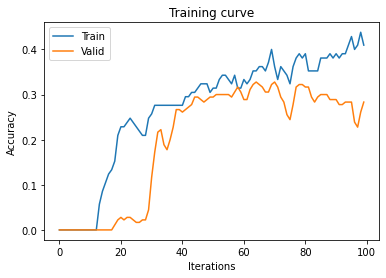

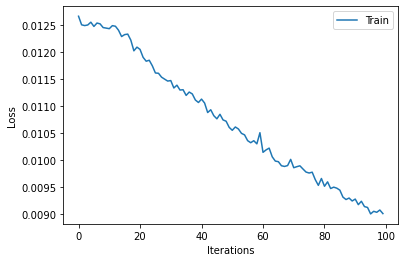

In [41]:
train2(cuda_tiny,tiny_train_data,tiny_valid_data,100,batch_size=30,learning_rate=0.0001,weight_decay=0.0001, checkpoint_path="./checkpoints/cuda_tiny/cuda_tiny-{}.pk")

In [47]:
cuda_tiny.load_state_dict(torch.load("./checkpoints/cuda_tiny/cuda_tiny-70.pk"))

<All keys matched successfully>

In [48]:
get_accuracy2(cuda_tiny,tiny_train_data)

tensor(0.6344, device='cuda:0')

{ man man on on orange while while skewers } } @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @ @


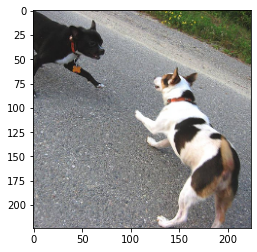

In [42]:
describe(1,cuda_tiny)

In [105]:
creature_captions[70]

'Skiiers walking up the hill through a forest '

In [23]:
big_pics = creature_imgs[:6500].to(device)
big_captions = get_padded_onehot_from_token([torch.Tensor(i) \
    for i in token_creature_captions[:6500]]).to(device)
big_dataset = My_Dataset(big_pics,big_captions)

In [41]:
cuda_big2 = caption_transformer(8,200,128,0.1).to(device)

In [42]:
train2(cuda_big2,big_dataset,valid_dataset,100,batch_size = 10,learning_rate=0.001,checkpoint_path="./checkpoints/cuda_big3/cuda_big3-{}.pk")

Iter 0. [Val Acc 71%] [Train Acc 77%, Loss 14.391928]
Iter 1. [Val Acc 75%] [Train Acc 79%, Loss 14.015168]
Iter 2. [Val Acc 74%] [Train Acc 79%, Loss 13.948922]
Iter 3. [Val Acc 71%] [Train Acc 75%, Loss 14.002985]
Iter 4. [Val Acc 64%] [Train Acc 70%, Loss 13.822186]
Iter 5. [Val Acc 62%] [Train Acc 68%, Loss 14.079101]
Iter 6. [Val Acc 62%] [Train Acc 68%, Loss 13.492567]
Iter 7. [Val Acc 62%] [Train Acc 68%, Loss 13.854090]
Iter 8. [Val Acc 62%] [Train Acc 68%, Loss 13.827053]
Iter 9. [Val Acc 62%] [Train Acc 68%, Loss 13.402293]
Iter 10. [Val Acc 62%] [Train Acc 68%, Loss 13.974092]
Iter 11. [Val Acc 62%] [Train Acc 68%, Loss 13.437254]
Iter 12. [Val Acc 62%] [Train Acc 68%, Loss 13.391090]
Iter 13. [Val Acc 62%] [Train Acc 68%, Loss 13.274633]
Iter 14. [Val Acc 62%] [Train Acc 68%, Loss 13.265341]
Iter 15. [Val Acc 62%] [Train Acc 68%, Loss 13.298415]
Iter 16. [Val Acc 62%] [Train Acc 68%, Loss 14.039495]
Iter 17. [Val Acc 62%] [Train Acc 68%, Loss 13.267296]
Iter 18. [Val Acc 62

KeyboardInterrupt: 

In [48]:
cuda_big2.load_state_dict(torch.load("./checkpoints/cuda_big2/cuda_big2-100.pk"))

<All keys matched successfully>

{4444444444444444444444444444444444444444444444))))))))444444)4))))4)4)4)4))))))))))))))))))4)4)4)4)4)4)4)44)4)4)4)444)4444444444)444444444)44444)4)4)4)4)4)4)4)4)4)4)4)4)4)4)4)4)4)4)4)4)4)4)4)4))))))4)


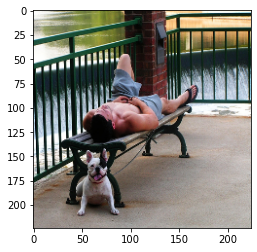

In [49]:
describe(3,cuda_big2)

In [27]:
cuda_big = caption_transformer(8,200,128).to(device)

TypeError: __init__() missing 1 required positional argument: 'dropout'

Iter 0. [Val Acc 74%] [Train Acc 79%, Loss 13.900478]
Iter 1. [Val Acc 74%] [Train Acc 78%, Loss 13.657545]
Iter 2. [Val Acc 75%] [Train Acc 79%, Loss 13.786930]
Iter 3. [Val Acc 75%] [Train Acc 79%, Loss 13.404690]
Iter 4. [Val Acc 76%] [Train Acc 79%, Loss 13.628830]
Iter 5. [Val Acc 76%] [Train Acc 78%, Loss 13.294572]
Iter 6. [Val Acc 75%] [Train Acc 78%, Loss 13.777825]
Iter 7. [Val Acc 74%] [Train Acc 77%, Loss 13.627735]
Iter 8. [Val Acc 74%] [Train Acc 77%, Loss 13.756401]
Iter 9. [Val Acc 74%] [Train Acc 76%, Loss 13.742941]
Iter 10. [Val Acc 74%] [Train Acc 76%, Loss 13.916074]
Iter 11. [Val Acc 73%] [Train Acc 75%, Loss 13.505187]
Iter 12. [Val Acc 72%] [Train Acc 74%, Loss 13.250066]
Iter 13. [Val Acc 72%] [Train Acc 75%, Loss 13.506605]
Iter 14. [Val Acc 10%] [Train Acc 7%, Loss 13.289197]
Iter 15. [Val Acc 10%] [Train Acc 7%, Loss 13.702599]
Iter 16. [Val Acc 9%] [Train Acc 6%, Loss 13.196721]
Iter 17. [Val Acc 9%] [Train Acc 6%, Loss 13.276464]
Iter 18. [Val Acc 8%] [Tra

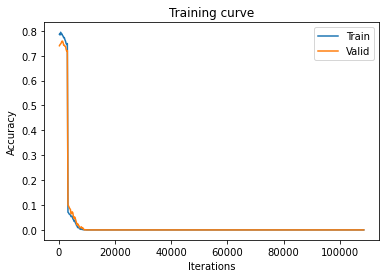

In [25]:
train2(cuda_big,big_dataset,valid_dataset,500,learning_rate=0.001,checkpoint_path="./checkpoints/cuda_big/cuda_big{}.pk")

In [47]:
for caption in creature_captions:
    if '2' in caption:
        print(caption)

About 12 kids and a few adults get splashed by an off camera source 
A crowd is watching 2 shirtless men , one in yellow pants and one in black shorts perfom 
A football player is in a red and white uniform Sooners # 28 
soldiers 2 and civillians sitting on a bench at a bussto
An african american woman with 2 young girls 
A football player has the number 25 
A brown dog is sniffing a white dog in front of 2 women 
2 People with white hats looking over the mountai
A man and 2 women in dark clothing 
One child in black is walking down a hill covered in white snow while 2 children are on their knees 
The 2 runners are ready for the track 
A dark-haired young woman , number 528 , wearing red and white , is preparing to throw a shot put 
A man in black is applauding a runner wearing a red jersey and the number 281 
There are 2 men dressed in stripes sitting under a green umbrella 
A girl in a black outfir is standing with 2 pug dog


In [34]:
cuda_big.load_state_dict(torch.load("./checkpoints/cuda_big/cuda_big0.pk"))

<All keys matched successfully>

{xxexbxxx , , , , , , , , , , , , , , , , , }@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


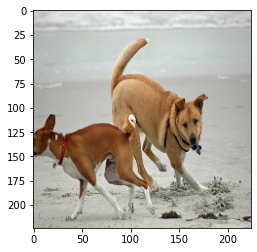

In [38]:
describe(20,cuda_big)

{222uxt-2-m22222-jumping 's-cl5ffq'}@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


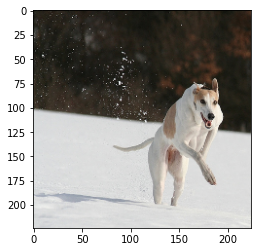

In [ ]:
describe(0,cuda_big)

In [ ]:
creature_captions[4]

'A man in an orange hat starring at something '

In [42]:
out = cuda_tiny(tiny_features[4].unsqueeze(0),tiny_captions[0].unsqueeze(0)[:,:-1,:])

In [43]:
''.join(get_sentence_from_onehot(out,vocab)[0])

"2 51ild-12 2qbq2k-jr22ss'2 j2omb'ng 2pq'q'qqt'ff'qrzrbt}nt'x}}x}-}}}a}}}@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@"

In [ ]:
cuda_tiny.make_tgt_mask(tiny_captions[4].unsqueeze(0)[:,:-1,:]).shape()

TypeError: 'torch.Size' object is not callable

In [ ]:
creature_captions[2]

'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl '

Small dataset

In [ ]:
# small_features = alexnet.features(creature_imgs[:20]).to(device)
# small_captions = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[:20]]).to(device)
# small_train_data = My_Dataset(small_features,small_captions)

In [ ]:
# small_transformer = caption_transformer(8,200,128).cuda()

In [ ]:
# train2(small_transformer,small_train_data,small_train_data,50,learning_rate=0.001)

In [ ]:
big_features = alexnet.features(creature_imgs[:2000]).to(device)
big_captions = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[:2000]]).to(device)
big_train_data = My_Dataset(big_features,big_captions)

In [ ]:
cuda_big = caption_transformer(8,200,128).to(device)

In [ ]:
valid_features = alexnet.features(creature_imgs[300:400]).to(device)
valid_captions = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[300:400]]).to(device)
valid_dataset = My_Dataset(valid_features,valid_captions)

In [ ]:
mini_batch = torch.utils.data.DataLoader(big_train_data,batch_size = 10,shuffle = True)


In [ ]:
for i in range(10):
    train2(cuda_big,big_train_data,valid_dataset,10,batch_size = 10,learning_rate=0.001,checkpoint_path="./checkpoints/cuda_big/" + str(i+1) +"/cuda-{}.pk")

KeyboardInterrupt: 

{a bouy wjoue jee wehee jue we we }


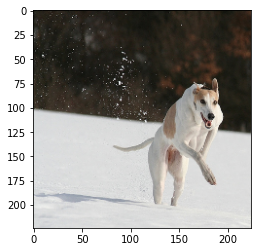

In [ ]:
describe(10,cuda_big)

In [ ]:
small_features = alexnet.features(creature_imgs[:2])
small_captions = token_creature_captions[:2]
small_train_data = My_Dataset(small_features,small_captions)

In [ ]:
big_features = alexnet.features(creature_imgs[:20])
big_captions = token_creature_captions[:20]
big_train_data = My_Dataset(big_features,big_captions)

In [ ]:
tiny_transformer = caption_transformer(8,200,128)

Iter 1. [Val Acc 8%] [Train Acc 10%, Loss 6.044424]
Iter 2. [Val Acc 7%] [Train Acc 8%, Loss 5.955259]
Iter 3. [Val Acc 16%] [Train Acc 19%, Loss 5.833477]
Iter 4. [Val Acc 22%] [Train Acc 25%, Loss 5.657168]
Iter 5. [Val Acc 18%] [Train Acc 18%, Loss 5.530747]
Iter 6. [Val Acc 23%] [Train Acc 19%, Loss 5.300127]
Iter 7. [Val Acc 33%] [Train Acc 29%, Loss 5.092812]
Iter 8. [Val Acc 38%] [Train Acc 45%, Loss 4.903758]
Iter 9. [Val Acc 37%] [Train Acc 37%, Loss 4.825968]
Iter 10. [Val Acc 37%] [Train Acc 42%, Loss 4.675734]
Iter 11. [Val Acc 41%] [Train Acc 47%, Loss 4.531961]
Iter 12. [Val Acc 53%] [Train Acc 48%, Loss 4.389147]
Iter 13. [Val Acc 47%] [Train Acc 52%, Loss 4.307577]
Iter 14. [Val Acc 52%] [Train Acc 53%, Loss 4.220446]
Iter 15. [Val Acc 51%] [Train Acc 60%, Loss 4.116037]
Iter 16. [Val Acc 58%] [Train Acc 62%, Loss 4.013468]
Iter 17. [Val Acc 66%] [Train Acc 58%, Loss 3.852261]
Iter 18. [Val Acc 66%] [Train Acc 62%, Loss 3.768493]
Iter 19. [Val Acc 64%] [Train Acc 63%, L

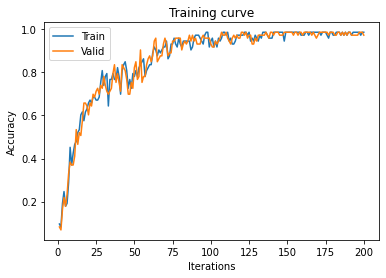

In [ ]:
train(tiny_transformer,tiny_train_data,tiny_train_data,200,learning_rate=0.001, weight_decay=0.001,checkpoint_path="./checkpoints/tiny/tiny-{}.pk") 

{a child in a pink dress is climbing up a set of stairs in an entry way } } a a ep wa wadrak wadray ata } wartafnt paawadrr}d wareruinoanha arssay ahsntaruwaia}cchenea}wawpp}}kaafng udrwcldpink a en}rr


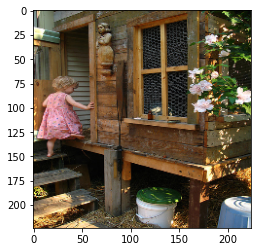

In [ ]:
describe(0,tiny_transformer)

In [ ]:
torch_small_features = alexnet.features(creature_imgs[:20])
torch_small_captions = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[:20]])
torch_small_dataset = My_Dataset(torch_small_features,torch_small_captions)

Iter 10. [Val Acc 45%] [Train Acc 45%, Loss 8.199138]
Iter 20. [Val Acc 45%] [Train Acc 44%, Loss 8.232787]
Iter 30. [Val Acc 49%] [Train Acc 49%, Loss 7.597566]
Iter 40. [Val Acc 55%] [Train Acc 55%, Loss 7.371503]
Iter 50. [Val Acc 58%] [Train Acc 58%, Loss 7.040907]
Iter 60. [Val Acc 60%] [Train Acc 60%, Loss 6.961380]
Iter 70. [Val Acc 60%] [Train Acc 61%, Loss 6.720640]
Iter 80. [Val Acc 61%] [Train Acc 61%, Loss 6.663387]
Iter 90. [Val Acc 64%] [Train Acc 64%, Loss 6.533018]
Iter 100. [Val Acc 65%] [Train Acc 65%, Loss 6.504898]
Iter 110. [Val Acc 67%] [Train Acc 67%, Loss 6.297341]
Iter 120. [Val Acc 68%] [Train Acc 68%, Loss 6.089076]
Iter 130. [Val Acc 69%] [Train Acc 68%, Loss 5.873305]
Iter 140. [Val Acc 73%] [Train Acc 74%, Loss 5.697863]
Iter 150. [Val Acc 71%] [Train Acc 71%, Loss 5.966898]
Iter 160. [Val Acc 76%] [Train Acc 75%, Loss 5.280979]
Iter 170. [Val Acc 78%] [Train Acc 78%, Loss 5.370174]
Iter 180. [Val Acc 79%] [Train Acc 78%, Loss 5.591033]
Iter 190. [Val Acc 

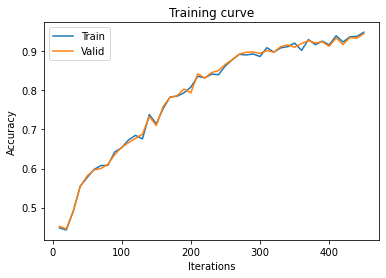

In [ ]:
small_transformer = caption_transformer(8,200,128)
train2(small_transformer,torch_small_dataset,torch_small_dataset,150,learning_rate=0.001, batch_size=7, weight_decay=0,checkpoint_path="./checkpoints/small/small-{}.pk")
    

{a couple and pink dovex, cuvg pjung jup f sexiv jxtyx}@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


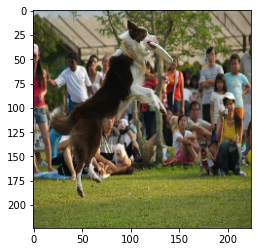

In [ ]:
describe(100,small_transformer)

In [ ]:
big_transformer = caption_transformer(8,200,128)

In [ ]:
big_transformer.load_state_dict(torch.load("./checkpoints/big/big-132.pk"))

<All keys matched successfully>

In [ ]:
torch_big_valid_features = alexnet.features(creature_imgs[300:320])
torch_big_valid_captions = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[300:320]])
torch_big_valid_dataset = My_Dataset(torch_big_valid_features, torch_big_valid_captions)

In [ ]:
torch_big_features = alexnet.features(creature_imgs[:200])
torch_big_captions = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[:200]])
torch_big_dataset = My_Dataset(torch_big_features,torch_big_captions)

In [ ]:
get_accuracy2(big_transformer,torch_big_dataset)

tensor(0.6483)

Iter 10. [Val Acc 37%] [Train Acc 64%, Loss 13.674301]
Iter 20. [Val Acc 36%] [Train Acc 63%, Loss 13.773527]
Iter 30. [Val Acc 33%] [Train Acc 61%, Loss 13.440783]
Iter 40. [Val Acc 9%] [Train Acc 47%, Loss 13.377572]
Iter 50. [Val Acc 35%] [Train Acc 63%, Loss 13.022572]
Iter 60. [Val Acc 43%] [Train Acc 68%, Loss 13.214210]
Iter 70. [Val Acc 50%] [Train Acc 72%, Loss 13.455306]
Iter 80. [Val Acc 51%] [Train Acc 72%, Loss 12.887723]
Iter 90. [Val Acc 51%] [Train Acc 72%, Loss 12.805061]
Iter 100. [Val Acc 52%] [Train Acc 73%, Loss 12.749903]
Iter 110. [Val Acc 53%] [Train Acc 73%, Loss 12.785296]
Iter 120. [Val Acc 52%] [Train Acc 73%, Loss 12.469347]
Iter 130. [Val Acc 52%] [Train Acc 73%, Loss 12.427953]
Iter 140. [Val Acc 52%] [Train Acc 72%, Loss 12.484476]
Iter 150. [Val Acc 50%] [Train Acc 71%, Loss 12.607816]
Iter 160. [Val Acc 49%] [Train Acc 71%, Loss 12.385218]
Iter 170. [Val Acc 52%] [Train Acc 73%, Loss 12.512590]
Iter 180. [Val Acc 51%] [Train Acc 73%, Loss 12.288288]
It

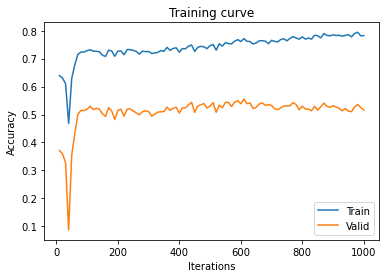

In [ ]:
train2(big_transformer,torch_big_dataset,torch_big_valid_dataset,50,batch_size = 10,learning_rate=0.001,weight_decay=0,checkpoint_path="./checkpoints/big/big-{}.pk")

In [ ]:
describe(0,big_transformer)

NameError: name 'big_transformer' is not defined

In [ ]:
creature_captions[10]

'A brown and white dog is running through the snow '

In [ ]:
start = torch.Tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]])


Iter 1. [Val Acc 53%] [Train Acc 54%, Loss 17.475039]
Iter 2. [Val Acc 21%] [Train Acc 24%, Loss 17.038582]
Iter 3. [Val Acc 65%] [Train Acc 65%, Loss 16.981627]
Iter 4. [Val Acc 66%] [Train Acc 67%, Loss 16.650639]
Iter 5. [Val Acc 69%] [Train Acc 68%, Loss 16.365370]
Iter 6. [Val Acc 69%] [Train Acc 69%, Loss 16.060644]
Iter 7. [Val Acc 69%] [Train Acc 69%, Loss 15.868306]
Iter 8. [Val Acc 72%] [Train Acc 71%, Loss 15.651612]
Iter 9. [Val Acc 70%] [Train Acc 71%, Loss 15.553219]
Iter 10. [Val Acc 71%] [Train Acc 72%, Loss 15.548039]
Iter 11. [Val Acc 68%] [Train Acc 68%, Loss 15.399825]
Iter 12. [Val Acc 69%] [Train Acc 69%, Loss 15.569022]
Iter 13. [Val Acc 72%] [Train Acc 72%, Loss 15.476325]
Iter 14. [Val Acc 71%] [Train Acc 71%, Loss 15.185826]
Iter 15. [Val Acc 71%] [Train Acc 71%, Loss 15.356575]
Iter 16. [Val Acc 71%] [Train Acc 72%, Loss 15.458107]
Iter 17. [Val Acc 71%] [Train Acc 71%, Loss 15.116787]
Iter 18. [Val Acc 71%] [Train Acc 72%, Loss 15.062333]
Iter 19. [Val Acc 7

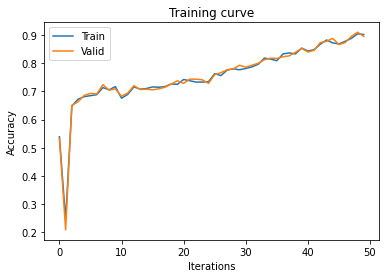

In [ ]:
small_transformer = caption_transformer(8)
train(small_transformer,small_train_data,small_train_data,learning_rate=0.001,num_epoches=50)

Iter 1. [Val Acc 77%] [Train Acc 76%, Loss 13.192142]
Iter 2. [Val Acc 79%] [Train Acc 79%, Loss 14.188063]
Iter 3. [Val Acc 85%] [Train Acc 82%, Loss 13.972493]
Iter 4. [Val Acc 86%] [Train Acc 87%, Loss 13.641713]
Iter 5. [Val Acc 88%] [Train Acc 88%, Loss 13.412138]
Iter 6. [Val Acc 88%] [Train Acc 89%, Loss 13.382388]
Iter 7. [Val Acc 89%] [Train Acc 88%, Loss 13.268505]
Iter 8. [Val Acc 89%] [Train Acc 88%, Loss 13.216901]
Iter 9. [Val Acc 89%] [Train Acc 88%, Loss 13.160680]
Iter 10. [Val Acc 90%] [Train Acc 89%, Loss 13.164543]
Iter 11. [Val Acc 90%] [Train Acc 89%, Loss 13.063646]
Iter 12. [Val Acc 91%] [Train Acc 91%, Loss 13.041174]
Iter 13. [Val Acc 92%] [Train Acc 94%, Loss 12.967552]
Iter 14. [Val Acc 93%] [Train Acc 92%, Loss 13.007338]
Iter 15. [Val Acc 94%] [Train Acc 93%, Loss 12.902250]
Iter 16. [Val Acc 94%] [Train Acc 95%, Loss 12.915670]
Iter 17. [Val Acc 95%] [Train Acc 95%, Loss 12.871367]
Iter 18. [Val Acc 94%] [Train Acc 94%, Loss 12.833856]
Iter 19. [Val Acc 9

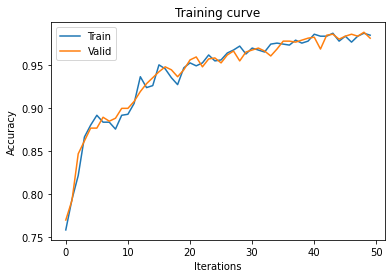

In [ ]:
train(small_transformer,small_train_data,small_train_data,learning_rate=0.001,num_epoches=50)

In [ ]:
get_accuracy(small_transformer,small_train_data)

tensor(0.9805)